<a href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/00_DESIGN_HomologSelection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 30.4 MB/s 


In [ ]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio import SeqIO
blast = True
import pathlib
from Bio.Blast import NCBIXML
import IPython

In [ ]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

Cloning into 'ConStrain_on_google_colab'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 221 (delta 68), reused 72 (delta 22), pack-reused 67
Receiving objects: 100% (221/221), 4.97 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (87/87), done.


### Intro

This notebook is made to be able to find homologs from protein queries. As a **test case** the G8H step in the Strictosidine pathway was chosen.  

**Some background on Strictosidine:** 
Strictosidine is a precurser for several anti-cancer compounds and is interesting because it is extracted from plants and due to weather and agricultural pests yields vary year to year (Brown et al., 2015). Additionally, Strictosidine is difficult to chemically synthesisze. These  therefore we therefore want to take the prouction  to a yeast cell factory. However, the G8H (G8H_reductase) part of the pathway is the limiting step of the pathway and we want to optimize that via combinatorial optimizition. We have therefore chosen this step as test case for developing algorithms that can standardize homolog selection. The pathway is shown below.

This notebook has been developed to answer the following question:

**Can we via algorithms determine and standardize homolog selection?** 


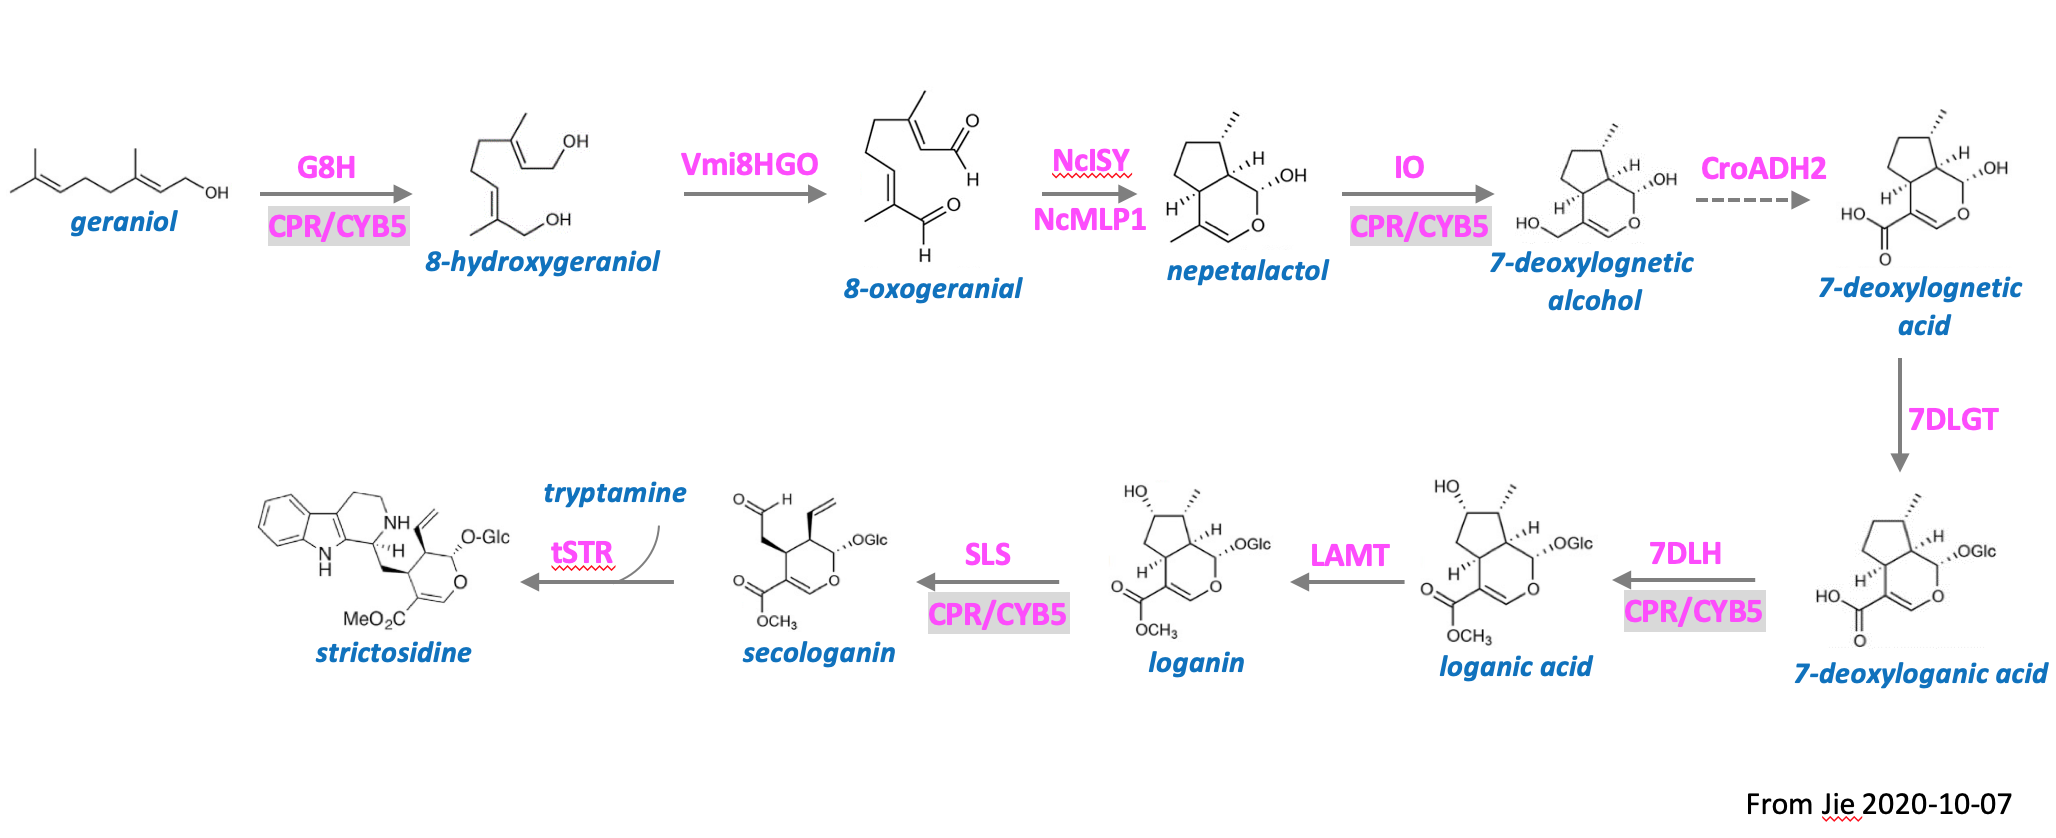

In [ ]:
IPython.core.display.Image('/content/ConStrain_on_google_colab/pictures/Pathway.png', width=800)

**Main objective:**

- Finding Homologs for G8H, a major bottleneck in the Strictosidine pathway. More specifically two groups: 
    - G8H-CYP (Cytochrome p450)
    - G8H-CPR (Cytochrome p450 reductase)

**The method/algorithm for finding the set of homologs is described as follows:**

1. Read in the protein sequence of interest
2. BLAST the sequence with the Biopython NCBIWWW.qblast function and select “blastp”. 
3. Search through the newly generated alignment XML file and find proteins that fit your parameters and save ACC numbers. Parameters included here are: 
    - Identity: 70-95% 
    - E-value threshold 0.04
4. The ACC numbers are then used for fetching the protein sequences and saved as a FASTA file. 
5. The protein sequences are then made into DNA sequences in a 2 step process.
6. A temporary DNA sequence is made from a translation table
7. Codon optimized with “DNA chisel” for the organism of choice.
8. The codon-optimized sequences are made into Biopython SeqRecord objects and can be: 
    - Exported to a database of choice through an API (Benchling, Teselagen)
    - Saved as a FASTA file. 

    

#### First we make a file path for the fasta file we want to blast

In [ ]:
p = '/content/ConStrain_on_google_colab/Data/Protein_seqs/Q8VWZ7 (1).FASTA'
pathCroG8H = pathlib.Path(p).resolve()
pathCroG8H

PosixPath('/content/ConStrain_on_google_colab/Data/Protein_seqs/Q8VWZ7 (1).FASTA')

#### Then we read it into a Seqrecord object with biopython

In [ ]:
croG8H = SeqIO.read(pathCroG8H, format="fasta")
croG8H


SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='sp|Q8VWZ7|C76B6_CATRO', name='sp|Q8VWZ7|C76B6_CATRO', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[])

In [ ]:
print(len(croG8H))

493


### Blasting it on NCBI

In [ ]:
%%time
result_handle = NCBIWWW.qblast("blastp", "nr", sequence=croG8H) # format_type='Text',

CPU times: user 298 ms, sys: 58.3 ms, total: 356 ms
Wall time: 1min 3s


#### Write the blast onto a file and close the results 

In [ ]:
blast_result = open("/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "w")
blast_result.write(result_handle.read())
blast_result.close()
result_handle.close()

#### THen open the generated file and read it into a variable 

In [ ]:
from Bio.Blast import NCBIXML

with open("/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "r") as result_handle:
    blast_record = NCBIXML.read(result_handle)

#### Filter BLAST results, on E-value, percentage protein identity - Here I chose 0.7 - 0.95 

In [ ]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.70
UPPER__PROTEIN_IDENTITY_THRESH = 0.99
Alignments_that_follow_our_criteria = [] #These are the ACC numbers

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH:
            counter += 1
            print("\nAlignment#", counter)
            print("Name:", alignment.hit_def)
            print("Title:", alignment.title)
            print("Length:", alignment.length)
            print("E value:", hsp.expect)
            print('Query:', hsp.query[0:75] + "...")
            print('Match:', hsp.match[0:75] + "...")
            print('Subjt:',hsp.sbjct[0:75] + "...")
            print('Identitiy', "{:.2f}".format(IDENTITY))
            print(alignment)
            
            # Saving the metrics we want into different lists
            Alignments_that_follow_our_criteria.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


Alignment# 1
Name: RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]
Title: sp|Q8VWZ7.1| RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]
Length: 493
E value: 3.09124e-27
Query: MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLSTL...
Match: MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL+ L...
Subjt: MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKL...
Identitiy 0.96
sp|Q8VWZ7.1| RecName: Full=Geraniol 8-hy

We can add the alignments into a dataframe

#### The alignments are saved onto a Bio.Blast.Record.Alignment datatype

In [ ]:
Alignments_that_follow_our_criteria[0].hit_def

'RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]'

In [ ]:
import pandas as pd

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_alignments_that_follow_our_criteria = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])
df_alignments_that_follow_our_criteria

,Name,Identity,E_value,Length,ACC_number
0,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus],0.964912,3.091240e-27,493,Q8VWZ7
1,geraniol 10-hydroxylase-like protein [Tabernaemontana elegans],0.754386,5.459160e-21,493,AGX93054
2,geraniol 10-hydroxylase-like protein [Amsonia hubrichtii],0.754386,3.197420e-20,493,AGX93052
3,geraniol 10-hydroxylase-like protein [Rauvolfia serpentina],0.754386,4.837300e-20,493,AGX93053
4,geraniol 10-hydroxylase-like protein [Cinchona calisaya],0.754386,1.244870e-19,493,AGX93051
5,geraniol 10-hydroxylase [Gentiana rigescens],0.754386,2.140110e-19,515,ANW12210
6,geraniol 10-hydroxylase [Gentiana rigescens],0.754386,2.161150e-19,515,ANW12211
7,geraniol 10-hydroxylase [Ophiorrhiza pumila],0.704918,2.317470e-19,512,BAP90522
8,G10H [Gentiana rigescens],0.736842,8.574130e-19,515,AIA22171
9,hypothetical protein BUALT_Bualt04G0118100 [Buddleja alternifolia],0.736842,8.646420e-19,310,KAG8384440


As a combinatorial library with 14 homologs would be to large we need to narrow down the candidtates. One way to do this is to select is to take a range of amino acid identeties. another way is to limit the length to be more similar to the native enzyme


In [ ]:
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] > len(croG8H)-15]
df_alignments_that_follow_our_criteria = df_alignments_that_follow_our_criteria[ df_alignments_that_follow_our_criteria['Length'] <len(croG8H)+15]
len(df_alignments_that_follow_our_criteria)

8

WE can add the native croG8H to the list 

In [ ]:
croG8H.id = 'Q8VWZ7'
croG8H

SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='Q8VWZ7', name='sp|Q8VWZ7|C76B6_CATRO', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[])

In [ ]:
G8H_dict = {'Name': croG8H.description, 'Identity': 1, 'E_value': 0, 'Length':len(croG8H.seq), 'ACC_number': croG8H.id }
G8H_df = pd.DataFrame([G8H_dict])

df_alignments_that_follow_our_criteria = pd.concat([G8H_df, df_alignments_that_follow_our_criteria], ignore_index=True)

In [ ]:
df_alignments_that_follow_our_criteria

,Name,Identity,E_value,Length,ACC_number
0,sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1,1.000000,0.000000e+00,493,Q8VWZ7
1,RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus],0.964912,3.091240e-27,493,Q8VWZ7
2,geraniol 10-hydroxylase-like protein [Tabernaemontana elegans],0.754386,5.459160e-21,493,AGX93054
3,geraniol 10-hydroxylase-like protein [Amsonia hubrichtii],0.754386,3.197420e-20,493,AGX93052
4,geraniol 10-hydroxylase-like protein [Rauvolfia serpentina],0.754386,4.837300e-20,493,AGX93053
5,geraniol 10-hydroxylase-like protein [Cinchona calisaya],0.754386,1.244870e-19,493,AGX93051
6,geraniol 8-hydroxylase-like [Olea europaea var. sylvestris],0.736842,1.384580e-18,494,XP_022858342
7,geraniol 10-hydroxylase [Olea europaea subsp. europaea],0.736842,1.454110e-18,494,CAA2993979
8,geraniol 10-hydroxylase [Olea europaea subsp. europaea],0.736842,1.588140e-18,494,CAA3016391


In [ ]:
acc_numbers = df_alignments_that_follow_our_criteria['ACC_number'].tolist()
Names_species = df_alignments_that_follow_our_criteria['Name'].tolist()
acc_numbers

['Q8VWZ7',
 'Q8VWZ7',
 'AGX93054',
 'AGX93052',
 'AGX93053',
 'AGX93051',
 'XP_022858342',
 'CAA2993979',
 'CAA3016391']

## Retrieve the sequences and write them onto a file

### Getting DNA sequences through Entrez 

Retrieve the sequences with the Entrez library which is possible with the ACC numbers we found before. Save the retrieved sequences as a fasta file called 'Homolog_seqs.fasta'. You need to provide an email for this so they know who you are. 

In [ ]:
from Bio import Entrez

In [ ]:
%%time

# add ur email here
email = "youremail@gmail.com"

out_handle = open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
out_handle.close()

CPU times: user 76.2 ms, sys: 12.9 ms, total: 89.1 ms
Wall time: 8.49 s


### Read the sequences into variables

Now parse through the file and get all the AA sequences which can be made into to DNA later. 

In [ ]:
fasta_sequences = SeqIO.parse(open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_Homolog_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')

print(len(sequences))

9


## Codon optimize it for yeast

We can use DNA chisel to backtranslate the sequences and afterwards codon optimize them. 

In [ ]:
!pip install dnachisel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 146 kB 4.3 MB/s 


In [ ]:
from dnachisel.biotools import reverse_translate

### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

9
ATGGATTATTTAACTATTATTTTAACTTTATTATTTGCTTTAACTTTATATGAAGCTTTTTCTTATTTATCTCGTCGTACTAAAAATTTACCTCCTGGTCCTTCTCCTTTACCTTTTATTGGTTCTTTACATTTATTAGGTGATCAACCTCATAAATCTTTAGCTAAATTATCTAAAAAACATGGTCCTATTATGTCTTTAAAATTAGGTCAAATTACTACTATTGTTATTTCTTCTTCTACTATGGCTAAAGAAGTTTTACAAAAACAAGATTTAGCTTTTTCTTCTCGTTCTGTTCCTAATGCTTTACATGCTCATAATCAATTTAAATTTTCTGTTGTTTGGTTACCTGTTGCTTCTCGTTGGCGTTCTTTACGTAAAGTTTTAAATTCTAATATTTTTTCTGGTAATCGTTTAGATGCTAATCAACATTTACGTACTCGTAAAGTTCAAGAATTAATTGCTTATTGTCGTAAAAATTCTCAATCTGGTGAAGCTGTTGATGTTGGTCGTGCTGCTTTTCGTACTTCTTTAAATTTATTATCTAATTTAATTTTTTCTAAAGATTTAACTGATCCTTATTCTGATTCTGCTAAAGAATTTAAAGATTTAGTTTGGAATATTATGGTTGAAGCTGGTAAACCTAATTTAGTTGATTTTTTTCCTTTATTAGAAAAAGTTGATCCTCAAGGTATTCGTCATCGTATGACTATTCATTTTGGTGAAGTTTTAAAATTATTTGGTGGTTTAGTTAATGAACGTTTAGAACAACGTCGTTCTAAAGGTGAAAAAAATGATGTTTTAGATGTTTTATTAACTACTTCTCAAGAATCTCCTGAAGAAATTGATCGTACTCATATTGAACGTATGTGTTTAGATTTATTTGTTGCTGGTACTGATACTACTTCTTCTACTTTAGAATGGGCTATGTCTGAAATGTTAAAAAATCCTGATAAAATGAAAAAAACTCAAGATGAATTAGCTCAAGTTATTGGTCG

### DNA chisel

Here the DNA is codon optimized for s_cerevisiae with DNA chisel

In [ ]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'G8H{}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs.append(final_record)

location:   0%|          | 0/129 [00:00<?, ?it/s, now=9-12]  
                                                           
location:   0%|          | 0/128 [00:00<?, ?it/s, now=9-12]  
                                                           
location: 100%|██████████| 128/128 [00:00<00:00, 818.62it/s, now=9-12]


In [ ]:
codon_optimized_seqs

[SeqRecord(seq=Seq('ATGGATTATTTGACTATTATTTTGACTTTGTTGTTTGCTTTGACTTTGTATGAA...TAA'), id='Q8VWZ7', name='G8H0', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTATTATTTTGACTTTGTTGTTTGCTTTGACTTTGTATGAA...TAA'), id='Q8VWZ7', name='G8H1', description='RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTTTGGTTTTGGGTTTGTTGTTTGCTTTGACTTTTTATCAA...TAA'), id='AGX93054', name='G8H2', description='geraniol 10-hydroxylase-like protein [Tabernaemontana elegans]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTATTGTTTTGGGTTTGTTGTTTGCTTTTACTTTTTATCAA...TAA'), id='AG

Writing the sequences into a fasta_file

In [ ]:
with open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CYP_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs)):
        print(codon_optimized_seqs[i].format("fasta"), file = outfile)

<!-- My_api_key:

4772e3e5-57ce-4b75-a3a8-06c49a2e202d -->

# Now for the CPR 

- The CPR was found in the article: De novo production of the plant-derived alkaloid strictosidine in yeast, under suplementary information
- From the fasta-file we have the CPR protein sequece and then we can repeat what was done above for finding SLS homologs 

In [ ]:
G8H_CPR = SeqIO.read('/content/ConStrain_on_google_colab/Data/Protein_seqs/Q05001SLS_cpr.fasta', format="fasta")
G8H_CPR

SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...VW*'), id='sp|Q05001|NCPR_CATRO', name='sp|Q05001|NCPR_CATRO', description='sp|Q05001|NCPR_CATRO NADPH--cytochrome P450 reductase OS=Catharanthus roseus OX=4058 GN=CPR PE=2 SV=1', dbxrefs=[])

In [ ]:
print(G8H_CPR.seq)

MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILTTSVAVLIGCVVVLIWRRSSGSGKKVVEPPKLIVPKSVVEPEEIDEGKKKFTIFFGTQTGTAEGFAKALAEEAKARYEKAVIKVIDIDDYAADDEEYEEKFRKETLAFFILATYGDGEPTDNAARFYKWFVEGNDRGDWLKNLQYGVFGLGNRQYEHFNKIAKVVDEKVAEQGGKRIVPLVLGDDDQCIEDDFAAWRENVWPELDNLLRDEDDTTVSTTYTAAIPEYRVVFPDKSDSLISEANGHANGYANGNTVYDAQHPCRSNVAVRKELHTPASDRSCTHLDFDIAGTGLSYGTGDHVGVYCDNLSETVEEAERLLNLPPETYFSLHADKEDGTPLAGSSLPPPFPPCTLRTALTRYADLLNTPKKSALLALAAYASDPNEADRLKYLASPAGKDEYAQSLVANQRSLLEVMAEFPSAKPPLGVFFAAIAPRLQPRFYSISSSPRMAPSRIHVTCALVYEKTPGGRIHKGVCSTWMKNAIPLEESRDCSWAPIFVRQSNFKLPADPKVPVIMIGPGTGLAPFRGFLQERLALKEEGAELGTAVFFFGCRNRKMDYIYEDELNHFLEIGALSELLVAFSREGPTKQYVQHKMAEKASDIWRMISDGAYVYVCGDAKGMARDVHRTLHTIAQEQGSMDSTQAEGFVKNLQMTGRYLRDVW*


In [ ]:
%%time
result_handle1 = NCBIWWW.qblast("blastp", "nr", sequence = G8H_CPR.seq)

CPU times: user 849 ms, sys: 125 ms, total: 973 ms
Wall time: 3min 2s


#### We write the blast onto a file so and close the results 

In [ ]:
blast_result1 = open("/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "w")
blast_result1.write(result_handle1.read())
blast_result1.close()
result_handle1.close()

#### THen we open the generated file and read it into a variable 

In [ ]:
from Bio.Blast import NCBIXML

with open("/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs.xml", "r") as result_handle1:
    blast_record = NCBIXML.read(result_handle1)

#### We can select the blast resulst we want on E-value and upper and lower percentage protein identity we want - Here we chose 0.7 - 0.95 

In [ ]:
E_VALUE_THRESH = 0.04
LOWER_PROTEIN_IDENTITY_THRESH = 0.76
UPPER__PROTEIN_IDENTITY_THRESH = 0.95
AA_length_min = 704
AA_length_max = 724
Alignments_that_follow_our_criteria1 = []

# saving some of the metrics
Names = []
Identity = []
E_value = []
Length = []
ACC_number = []

counter = 0
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        IDENTITY = (hsp.identities/ hsp.align_length)
        LENGTH = alignment.length 
        # We add the added reqirement that the sequence should be +-10 amino acids 
        if hsp.expect < E_VALUE_THRESH and IDENTITY > LOWER_PROTEIN_IDENTITY_THRESH and IDENTITY < UPPER__PROTEIN_IDENTITY_THRESH and LENGTH > AA_length_min and LENGTH<AA_length_max :
            counter += 1
#             print("\nAlignment#", counter)
#             print("Name:", alignment.hit_def)
#             print("Title:", alignment.title)
#             print("Length:", alignment.length)
#             print("E value:", hsp.expect)
#             print('Query:', hsp.query[0:75] + "...")
#             print('Match:', hsp.match[0:75] + "...")
#             print('Subjt:',hsp.sbjct[0:75] + "...")
#             print('Identitiy', "{:.2f}".format(IDENTITY))
            
            # Saving into different lists
            Alignments_that_follow_our_criteria1.append(alignment)
            Names.append(alignment.hit_def)
            Identity.append(IDENTITY)
            E_value.append(hsp.expect)
            Length.append(alignment.length)
            ACC_number.append(alignment.accession)
            
print('\nTOTAL HOMOLOGS', counter)


TOTAL HOMOLOGS 42


Now we can sort the results in a dataframe 

In [ ]:
data = list(zip(Names,Identity, E_value, Length, ACC_number))
df_with_CPR = pd.DataFrame(data, columns=['Name','Identity', 'E_value', 'Length', 'ACC_number'])
df_with_CPR = df_with_CPR.sort_values(by=['Identity'])
df_with_CPR

,Name,Identity,E_value,Length,ACC_number
33,hypothetical protein L6452_26953 [Arctium lappa],0.766434,0.0,709,KAI3701692
31,NADPH--cytochrome P450 reductase-like [Cynara cardunculus var. scolymus],0.773743,0.0,709,XP_024960139
25,PREDICTED: NADPH--cytochrome P450 reductase-like [Erythranthe guttata] >gb|EYU20907.1| hypothetical protein MIMGU_mgv1a002097mg [Erythranthe guttata],0.775140,0.0,715,XP_012857359
22,NADPH--cytochrome P450 reductase-like [Salvia hispanica],0.777622,0.0,712,XP_047948004
40,cytochrome P450 oxidoreductase [Ocimum basilicum],0.777622,0.0,707,AGC92176
37,NADPH--cytochrome P450 reductase [Vitis riparia],0.777933,0.0,705,XP_034699648
15,NADPH--cytochrome P450 reductase-like [Salvia splendens] >gb|KAG6430878.1| hypothetical protein SASPL_108951 [Salvia splendens],0.777933,0.0,713,XP_042050280
36,NADPH--cytochrome P450 reductase [Vitis vinifera],0.779330,0.0,705,RVW75508
35,PREDICTED: NADPH--cytochrome P450 reductase [Vitis vinifera],0.779330,0.0,705,XP_002270732
39,NADPH--cytochrome P450 reductase-like [Salvia splendens],0.780420,0.0,712,XP_042002725


We get 44 alignments which is a bit much so we will have to narrow it down to make a library of feasible size. 

Lets try to sample every 6 from the sorted dataframe. THat way we get CPRs that have different amino acid identities and reduce the number of parts. 


In [ ]:
rate = 5
subset = df_with_CPR[::rate]
subset

,Name,Identity,E_value,Length,ACC_number
33,hypothetical protein L6452_26953 [Arctium lappa],0.766434,0.0,709,KAI3701692
37,NADPH--cytochrome P450 reductase [Vitis riparia],0.777933,0.0,705,XP_034699648
17,NADPH--cytochrome P450 reductase-like [Ipomoea triloba],0.780420,0.0,709,XP_031108978
32,NADPH-cytochrome P450 reductase [Ocimum basilicum],0.783217,0.0,710,ANW46529
23,NADPH-dependent cytochrome P450 reductase [Camptotheca acuminata],0.787709,0.0,708,QNL13420
16,cytochrome P450 reductase [Salvia miltiorrhiza],0.795804,0.0,712,AGL46979
2,NADPH--cytochrome P450 reductase-like [Olea europaea var. sylvestris],0.801120,0.0,708,XP_022867604
4,NADPH--cytochrome P450 reductase-like [Olea europaea var. sylvestris],0.803922,0.0,708,XP_022887951
1,NADPH--cytochrome P450 reductase-like [Coffea arabica],0.837535,0.0,712,XP_027072686


In [ ]:
acc_numbers = subset['ACC_number'].tolist()
acc_numbers

['KAI3701692',
 'XP_034699648',
 'XP_031108978',
 'ANW46529',
 'QNL13420',
 'AGL46979',
 'XP_022867604',
 'XP_022887951',
 'XP_027072686']

In [ ]:
# We can add the native CPR to the mix
acc_numbers.append('Q05001')
Names_species.append('NCPR_CATRO NADPH--cytochrome P450 reductase [Catharanthus roseus]')

In [ ]:
len(acc_numbers)

10

Now we blast we get all the sequences from the accession numbers

In [ ]:
%%time

email = "youremail@gmail.com"

out_handle = open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta', "w")

for i in range(0, len(acc_numbers)):
    Entrez.email = email
    handle = Entrez.efetch(db="protein", id=acc_numbers[i], rettype="fasta", retmode="text")
    
    out_handle.write(handle.read())
    
out_handle.close()

CPU times: user 86 ms, sys: 19.7 ms, total: 106 ms
Wall time: 9.66 s


### Read in the sequences into variables


Now we can parse through the file and get all the AA sequences which we can make to DNA later. 

In [ ]:
fasta_sequences = SeqIO.parse(open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homolog_protein_seqs.fasta'),'fasta')
names = []
sequences = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    sequences.append(str(sequence)+'*')
    

## Codon optimize it for yeast

We can do the same as before of first making a dummy dna sequence with the use of the synbiopython translation table

In [ ]:
### First we just make a dummy dna sequece from the protein seq
protein_to_dna = []

for i in range(0, len(sequences)): 
    aa_seq = str(sequences[i])
    protein_to_dna.append(reverse_translate(aa_seq))
print(len(protein_to_dna))
print(protein_to_dna[1]) 

10
ATGCAATCTTCTTCTGTTAAAGTTTCTCCTTTTGATTTAATGTCTGCTATTATTAAAGGTTCTATGGATCAATCTAATGTTTCTTCTGAATCTGGTGGTGCTGCTGCTATGGTTTTAGAAAATCGTGAATTTATTATGATTTTAACTACTTCTATTGCTGTTTTAATTGGTTGTGTTGTTGTTTTAATTTGGCGTCGTTCTGGTCAAAAACAATCTAAAACTCCTGATCCTCCTAAACCTTTAATTGTTAAAGATTTAGAAGTTGAAGTTGATGATGGTAAACAAAAAGTTACTATTTTTTTTGGTACTCAAACTGGTACTGCTGAAGGTTTTGCTAAAGCTTTAGCTGAAGAAGCTAAAGCTCGTTATGAAAAAGCTATTTTTAAAGTTGTTGATTTAGATGATTATGCTGGTGATGATGATGAATATGAAGAAAAATTAAAAAAAGAAACTTTAGCTTTTTTTTTTTTAGCTACTTATGGTGATGGTGAACCTACTGATAATGCTGCTCGTTTTTATAAATGGTTTGCTGAAGGTAAAGAACGTGGTGAATGGTTACAAAATTTAAAATATGGTGTTTTTGGTTTAGGTAATCGTCAATATGAACATTTTAATAAAGTTGCTAAAGTTGTTGATGATATTATTACTGAACAAGGTGGTAAACGTATTGTTCCTGTTGGTTTAGGTGATGATGATCAATGTATTGAAGATGATTTTGCTGCTTGGCGTGAATTATTATGGCCTGAATTAGATCAATTATTACGTGATGAAGATGATGCTACTACTGTTTCTACTCCTTATACTGCTGCTGTTTTAGAATATCGTGTTGTTTTTCATGATCCTGAAGGTGCTTCTATGCAAGATAAAACTTGGGGTTCTGCTAATGGTCATACTGTTCATGATGCTCAACATCCTTGTCGTGCTAATGTTGCTGTTCGTAAAGAATTACATACTCCTGCTTCTGATCGTTCTTGTACTCATTTAGAATTTGATATTT

### Now for making codon_optimized DNA from our protein sequences:  DNA chisel

In [ ]:
### Using DNA chisel to optimize the pattern: 

from dnachisel import *

codon_optimized_seqs1 = []

# DEFINE THE OPTIMIZATION PROBLEM
for i in range(0, len(protein_to_dna)):
    problem = DnaOptimizationProblem(
        sequence=protein_to_dna[i], 
        constraints=[EnforceGCContent(mini=0.3, maxi=0.7)],
        objectives=[CodonOptimize(species='s_cerevisiae')]
    )

    # SOLVE THE CONSTRAINTS, OPTIMIZE WITH RESPECT TO THE OBJECTIVE
    problem.resolve_constraints()
    problem.optimize()

    # GET THE FINAL SEQUENCE AS ANNOTATED BIOPYTHON RECORDS)
    final_record = problem.to_record(with_sequence_edits=True)
    final_record.id = acc_numbers[i]
    final_record.name = 'G8H_CPR {}'.format(i)
    final_record.description = Names_species[i]
    
    codon_optimized_seqs1.append(final_record)

location: 100%|██████████| 139/139 [00:00<00:00, 1015.80it/s, now=21-24]


In [ ]:
codon_optimized_seqs1

[SeqRecord(seq=Seq('ATGCAATCTAATTCTGTTAAAGTTTCTCCATTTGATTTGATGTCTGCTATTTTT...TAA'), id='KAI3701692', name='G8H_CPR 0', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGCAATCTTCTTCTGTTAAAGTTTCTCCATTTGATTTGATGTCTGCTATTATT...TAA'), id='XP_034699648', name='G8H_CPR 1', description='RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H [Catharanthus roseus] >gb|AHA82034.1| geraniol 10-hydroxylase [Catharanthus roseus] >gb|AJO70761.1| geraniol-8-hydroxylase [synthetic construct] >emb|CAC80883.1| geraniol 10-hydroxylase [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGAACCAACTTCTGAAAAATTGTCTCCATTTGATTTTATGGCTGCTATTTTT...TAA'), id='XP_031108978', name='G8H_CPR 2', description='geraniol 10-hydroxylase-like protein [Tabernaemontana elegans]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGAATCTACTTCTGAAAAATTGTCTCCATTTGATTTTAT

Writing the sequences into a fasta_file

In [ ]:
with open('/content/ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_seqs1)):
        print(codon_optimized_seqs1[i].format("fasta"), file = outfile)

## Does the the SLS_CYP and SLS_CPR share too much homology? 

One way to figure this out is to use the Clustal Omega online tool: https://www.ebi.ac.uk/Tools/msa/clustalo/

1. Upload fasta file with all sequences
2. THis was done and a lot of homology was found between the SLS CPR and CYP. This information can be found in the files folder


We can present the result visually as a phylogenetic tree as shown below.

In [ ]:
display.Image('/content/ConStrain_on_google_colab/pictures/PHYLO_G8H_CYP_CPR.png')

AttributeError: ignored

Here it is clear that the CYPs and CPRs are clustered into their own clades. However, when looking closely at the clustal omega file there are found streches of DNA that show homology which could be a problem for integration. 

This problem could be alliviated by:
1. Integrateting the CYPs and CPRs seperately in different genomic locations. 
2. Changing the parameters of the Codon optimization in either the CYP step or the CPR step, or constraing DNA chisel to avoid the same sequences. DNA chisel has the UniquifyAllKmers to do this. 

### Conclusion 

- 8 G8H CYPs were found and codon-optimized
- 10 CPRs were found and codon-optimized

## References: 
    
    
    

Brown, S., Clastre, M., Courdavault, V. and O’Connor, S., 2015. De novo production of the plant-derived alkaloid strictosidine in yeast. Proceedings of the National Academy of Sciences, 112(11), pp.3205-3210.